### Cifar10 autoencoder
-The goal of this project is to create an autoencoder with a pre-specified architecture that is trained on the images in the CIFAR 10 data set, which contains 60,000 32x32 color images of 10 different classes.

-Here is a link to the dataset: https://www.cs.toronto.edu/~kriz/cifar.html

-I use the pytorch library for the implementation of this project.

-This is my unique solution to a project created for Mike X Cohen's "A Deep Understanding of Deep Learning Class"

-Much of the code is adapted from this course.



In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset,Subset
import copy
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pandas as pd


# for importing data
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/Users/benjaminmellin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/dw/n4jtvcxx0gl3p_mb684zhpq00000gn/T/ipykernel_74814/835225465.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# download the dataset
# download the CIFAR10 dataset

transform = T.Compose([ T.ToTensor(),
                        T.Normalize([.5,.5,.5],[.5,.5,.5])
                       ])
trainset = torchvision.datasets.CIFAR10(root='cifar10',train = True, download=True, transform = transform)
testset = torchvision.datasets.CIFAR10(root='cifar10', train = False, download=True, transform=transform)


# Remove the label from the dataset, leaving only the image data
trainset = [element[0] for element in trainset]
testset = [element[0] for element in testset]

0.1%

100.0%


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


In [3]:
def createTheCIFARAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

            ### input layer
            # encoding layer
      self.enc = nn.Sequential(
        nn.Conv2d(3,16,4,padding=1,stride=2),
        # output size: (32+2*1-4)/2 + 1 = 16
        nn.LeakyReLU(),
        nn.Conv2d(16,32,4,padding=1,stride=2),
        # output size: (16+2*1-4)/2 + 1 = 8
        nn.LeakyReLU(),
        nn.Conv2d(32,64,4,padding=1,stride=2),
        nn.LeakyReLU()
        )

        #decoding layer
      self.dec = nn.Sequential(
        nn.ConvTranspose2d(64,32,4,padding=1,stride=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(32,16,4,padding=1,stride=2),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16,3,4,padding=1,stride=2)
        )

    def forward(self,x):
      return self.dec( self.enc(x) )

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer


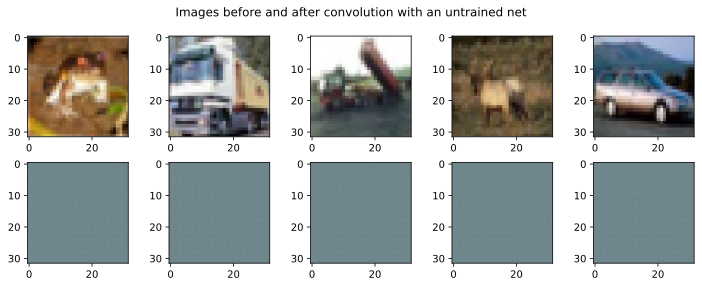

In [4]:
# test the untrained model with some images
net,lossfun,optimizer = createTheCIFARAE()

fig,axs = plt.subplots(2,5,figsize=(10,4))

for i in range(5):
  yHat = net(trainset[i])

  #Reshape the images into right image format
  I = yHat.detach().numpy().transpose((1,2,0))
  J = trainset[i].detach().numpy().transpose((1,2,0))
  J=J/2 + .5
  I=I/2 + .5

  axs[1][i].imshow(I)
  axs[0][i].imshow(J)



plt.suptitle("Images before and after convolution with an untrained net")
plt.tight_layout()
plt.show()

In [5]:
# Train the Net

def function2trainTheModel():

  # number of epochs
  numepochs = 750

  # initialize losses
  trainlosses = torch.zeros(numepochs)
  testlosses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random

    pics2use = np.random.choice(len(trainset),size=32,replace=False)
    X = [trainset[pic] for pic in pics2use]

    net.train()

    #initialize batchloss
    batchlosses = torch.zeros(len(X))

    for i in range(len(X)):

      # forward pass and loss
      yHat = net(X[i])
      loss = lossfun(yHat,X[i])
      batchlosses[i] = loss.item()

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    trainlosses[epochi] = torch.mean(batchlosses)

    net.eval()

    # Get losses on test data

    # Get images from test set
    pics2use = np.random.choice(len(testset),size=32,replace=False)
    X = [testset[pic] for pic in pics2use]

    # initialize batchloss
    batchlosses = torch.zeros(len(X))

    for i in range(len(X)):

      #forward pass and loss
      yHat = net(X[i])
      loss = lossfun(yHat,X[i])
      batchlosses[i] = loss.item()

    testlosses[epochi] = torch.mean(batchlosses)

  # end epochs

  # function output
  return trainlosses,testlosses,net



In [6]:
# test the model on a bit of data
trainlosses,testlosses,net = function2trainTheModel()

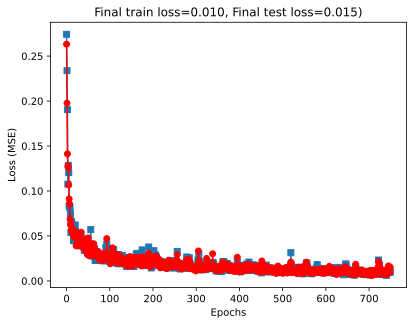

In [7]:
#plot the losses

plt.plot(trainlosses,'s-',label='Train')
plt.plot(testlosses,'o-', color="red", label='Test',)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Final train loss=%.3f, Final test loss=%.3f)' % (trainlosses[-1], testlosses[-1]))

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


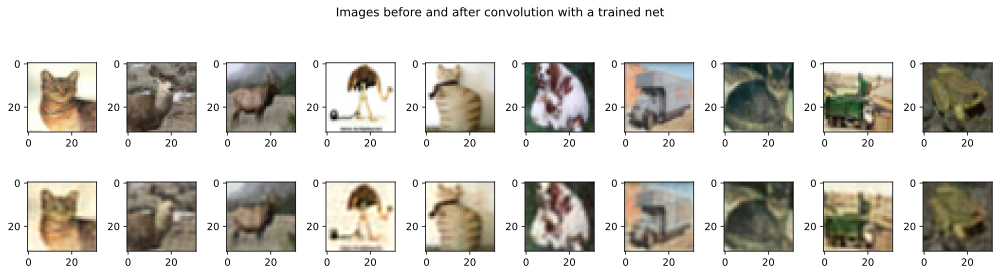

In [8]:
# Visualize images through the trained network

fig,axs = plt.subplots(2,10,figsize=(14,4))

pics2see = np.random.choice(len(testset),size=10,replace=False)

for i in range(len(pics2see)):
  yHat = net(testset[pics2see[i]])

  #Reshape the images into right image format
  I = yHat.detach().numpy().transpose((1,2,0))
  J = testset[pics2see[i]].detach().numpy().transpose((1,2,0))
  J=J/2 + .5
  I=I/2 + .5

  axs[1][i].imshow(I)
  axs[0][i].imshow(J)



plt.suptitle("Images before and after convolution with a trained net")
plt.tight_layout()
plt.show()